In [1]:
import pennylane as qml
import random
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../')

In [2]:
device='cpu'

# Quantum Circuit

In [3]:
date = '20211119_103657'

resume_iters = 120

test_sample_size = 10000

layer = 1

qubits = 8

In [4]:
dev = qml.device('default.qubit', wires=qubits)
@qml.qnode(dev, interface='torch', diff_method='backprop')
def gen_circuit(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layer):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [5]:
model_dir_path = r'/home/ken/projects/QuantumGAN-PyTorch/results/quantum-GAN/'+date+'/train/model_dir'

weights_pth = os.path.join(model_dir_path, 'molgan_red_weights.csv')

weights = pd.read_csv(weights_pth, header=None).iloc[resume_iters-1, 1:].values

gen_weights = torch.tensor(list(weights), requires_grad=True)

In [6]:
drawer = qml.draw(gen_circuit)
print(drawer(gen_weights))

 0: ──RY(-1.08)──RZ(-0.491)──RY(-0.708)──╭C──────────────╭C──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ ⟨Z⟩ 
 1: ──RY(-1.08)──RZ(-0.491)──RY(1.39)────╰X──RZ(-0.387)──╰X──╭C───────────────╭C─────────────────────────────────────────────────────────────────────────────────────────────────┤ ⟨Z⟩ 
 2: ──RY(-1.08)──RZ(-0.491)──RY(-0.642)──────────────────────╰X──RZ(-0.0404)──╰X──╭C────────────╭C───────────────────────────────────────────────────────────────────────────────┤ ⟨Z⟩ 
 3: ──RY(-1.08)──RZ(-0.491)──RY(1.71)─────────────────────────────────────────────╰X──RZ(-3.1)──╰X──╭C──────────────╭C───────────────────────────────────────────────────────────┤ ⟨Z⟩ 
 4: ──RY(-1.08)──RZ(-0.491)──RY(2.2)────────────────────────────────────────────────────────────────╰X──RZ(-0.138)──╰X──╭C──────────────╭C───────────────────────────────────────┤ ⟨Z⟩ 
 5: ──RY(-1.08)──RZ(-0.491)──RY(1.85)───────────────────────────────────────────

In [7]:
sample_list = [gen_circuit(gen_weights) for i in range(test_sample_size)]

# Data

In [8]:
from data.sparse_molecular_dataset import SparseMolecularDataset

In [9]:
mol_data_dir = 'data/gdb9_9nodes.sparsedataset'

In [10]:
data = SparseMolecularDataset()

data.load(mol_data_dir)

# Generator

In [11]:
from models.models import Generator, Discriminator

In [12]:
complexity = 'mr'

z_dim = qubits

dropout = 0.0

In [13]:
if complexity == 'nr':
    g_conv_dim = [128, 256, 512]
elif complexity == 'mr':
    g_conv_dim = [128]
elif complexity == 'hr':
    g_conv_dim = [16]
else:
    raise ValueError("Please enter an valid model complexity from 'mr', 'hr' or 'nr'!")

In [14]:
G = Generator(g_conv_dim, z_dim, data.vertexes, data.bond_num_types, data.atom_num_types, dropout)

In [15]:
G.to(device)

Generator(
  (activation_f): Tanh()
  (multi_dense_layers): MultiDenseLayers(
    (activation): Tanh()
    (linear_layers): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.0, inplace=False)
    )
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [16]:
G_path = os.path.join(model_dir_path, '{}-G.ckpt'.format(resume_iters))

In [17]:
G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))

<All keys matched successfully>

# Generating Molecules

In [18]:
import torch.nn.functional as F

In [19]:
z = torch.stack(tuple(sample_list)).to(device).float()

In [20]:
corr_matrix = np.corrcoef(z.detach().numpy()).round(decimals=2)

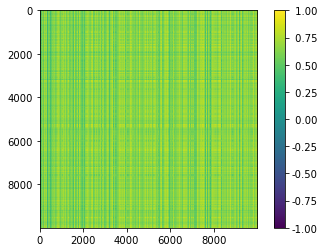

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
ax.grid(False)
plt.show()

In [22]:
post_method = 'softmax'

In [23]:
edges_logits, nodes_logits = G(z)

In [24]:
def postprocess(inputs, method, temperature=1.0):
    def listify(x):
        return x if type(x) == list or type(x) == tuple else [x]
    def delistify(x):
        return x if len(x) > 1 else x[0]
    if method == 'soft_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=False).view(e_logits.size()) for e_logits in listify(inputs)]
    elif method == 'hard_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=True).view(e_logits.size()) for e_logits in listify(inputs)]
    else:
        softmax = [F.softmax(e_logits/temperature, -1) for e_logits in listify(inputs)]
    return [delistify(e) for e in (softmax)]

In [25]:
(edges_hat, nodes_hat) = postprocess((edges_logits, nodes_logits), post_method)   

In [26]:
def get_gen_mols(data, n_hat, e_hat, method):
    (edges_hard, nodes_hard) = postprocess((e_hat, n_hat), method)
    edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
    mols = [data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True) for e_, n_ in zip(edges_hard, nodes_hard)]
    return mols

In [27]:
mols = get_gen_mols(data, nodes_logits, edges_logits, post_method)

RDKit ERROR: [20:37:28] non-ring atom 1 marked aromatic
[20:37:28] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:28] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:28] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:28] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:28] non-ring atom 4 marked aromatic
[20:37:28] non-ring atom 1 marked aromatic
[20:37:28] non-ring atom 0 marked aromatic
[20:37:28] non-ring atom 0 marked aromatic
[20:37:28] non-ring atom 4 marked aromatic
RDKit ERROR: [20:37:28] non-ring atom 0 marked aromatic
[20:37:28] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:28] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:28] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:28] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:28] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:28] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:28] non-ring atom 1 marked aromatic
[20:37:28] non-ring atom 1 marked aromatic
[20:37:28]

RDKit ERROR: [20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
[20:37:29] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] Can't kekulize mol.  Unkekulized atoms: 1 4 8
[20:37:29] Can't kekulize mol.  Unkekulized atoms: 1 4 8

RDKit ERROR: 
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [20:37:29] non-ring atom 0 marked aromatic
[20:37:29] Explicit

[20:37:29] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] Can't kekulize mol.  Unkekulized atoms: 3 6

[20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] Can't kekulize mol.  Unkekulized atoms: 1
[20:37:29] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] Can't kekulize mol.  Unkekulized atoms: 1

RDKit ERROR: 
RDKit ERROR: [20:37:29] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 7 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] Can't kekulize mol.  Unkekulized atoms: 1 8
RDKit ERROR: 
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 7 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] Can

RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:29] Can't kekulize mol.  Unkekulized atoms: 8
RDKit ERROR: 
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] Can't kekulize mol.  Unkekulized atoms: 8

RDKit ERROR: [20:37:29] Explicit valence for atom # 2 O, 4, is greater than permitted
[20:37:29] Explicit valence for atom # 2 O, 4, is greater than permitted
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 7 marked aromatic
RDKit ERROR: [

[20:37:29] Can't kekulize mol.  Unkekulized atoms: 1 4 8

[20:37:29] Can't kekulize mol.  Unkekulized atoms: 1 8

[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 4 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 4 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1

RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] Explicit valence for atom # 4 C, 5, is greater than permitted
[20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 1 marked aromatic
[20:37:29] non-ring atom 0 marked aromatic
RDKit 

RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERRO

[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 7 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30]

RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
RDKit ERROR: [20:37:30] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:30] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [20:37:30] non-ring atom 1 marked ar

non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] Explicit valence for atom # 6 O, 3, is greater than permitted
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] Can't kekulize mol.  Unkekulized atoms: 1

[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:

[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] Can't kekulize mol.  Unkekulized atoms: 1 8

[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 4 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] Can't kekulize mol.  Unkekulized atoms: 1 4 8

[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:30] Explicit valence for atom # 

# Scores

In [28]:
from utils.utils import *

[20:37:30] non-ring atom 7 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 7 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] Can't kekulize mol.  Unkekulized atoms: 1

[20:37:30] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 0 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 4 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] non-ring atom 1 marked aromatic
[20:37:30] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:37:30] Can't kekulize mol.  Unkekul

In [29]:
m0, m1 = all_scores(mols, data, norm=True)

In [30]:
from collections import defaultdict

scores = defaultdict(list)

for k, v in m1.items():
    scores[k].append(v)
for k, v in m0.items():
    scores[k].append(np.array(v)[np.nonzero(v)].mean())

In [31]:
scores

defaultdict(list,
            {'valid': [70.02999782562256],
             'unique': [2.741682136227331],
             'novel': [85.12066257318293],
             'NP': [0.9533800823021866],
             'QED': [0.5224553300012522],
             'Solute': [0.396342711823013],
             'SA': [0.419522962058126],
             'diverse': [0.7063818525605806],
             'drugcand': [0.42457811862675426]})

In [32]:
benchmarking_scores = ['NP', 'QED', 'Solute', 'SA', 'drugcand']

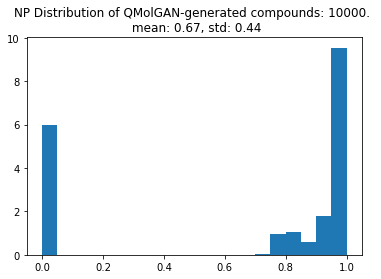

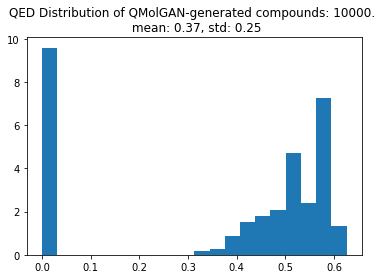

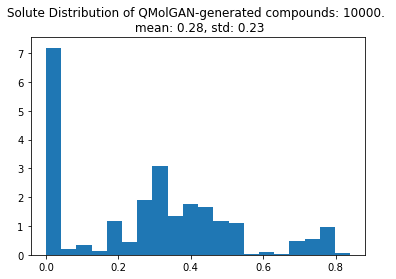

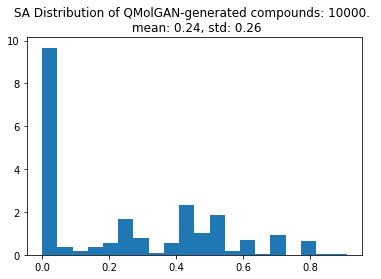

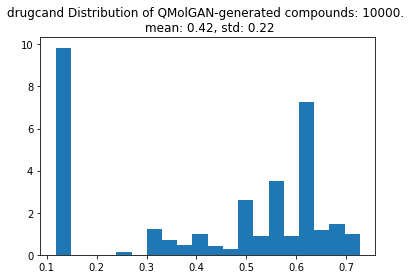

In [33]:
for idx, score in enumerate(benchmarking_scores):
    mols_score = m0[score]
    mols_score_avg = sum(mols_score)/len(mols_score)
    mols_score_std = np.std(mols_score)
    plt.figure(idx)
    plt.hist(mols_score, bins=20, density=True)
    plt.title(score + ' Distribution of QMolGAN-generated compounds: {}. \n mean: {:.2f}, std: {:.2f}'.format(len(mols_score), mols_score_avg, mols_score_std))

# Unique Molecules Scores

In [34]:
v = MolecularMetrics.valid_filter(mols)

In [35]:
s = set(map(lambda x: Chem.MolToSmiles(x), v))

In [36]:
unique_mols = list(map(lambda x: Chem.MolFromSmiles(x), s))

In [37]:
unique_valid_mols = MolecularMetrics.valid_filter(unique_mols)

In [38]:
len(unique_valid_mols)

192

In [39]:
from rdkit.Chem import Draw

unique_mols = list(map(lambda x: Chem.MolFromSmiles(x), s))

In [40]:
from rdkit.Chem import Draw

img=Draw.MolsToGridImage(unique_valid_mols,molsPerRow=8,subImgSize=(200,200), maxMols=500)    

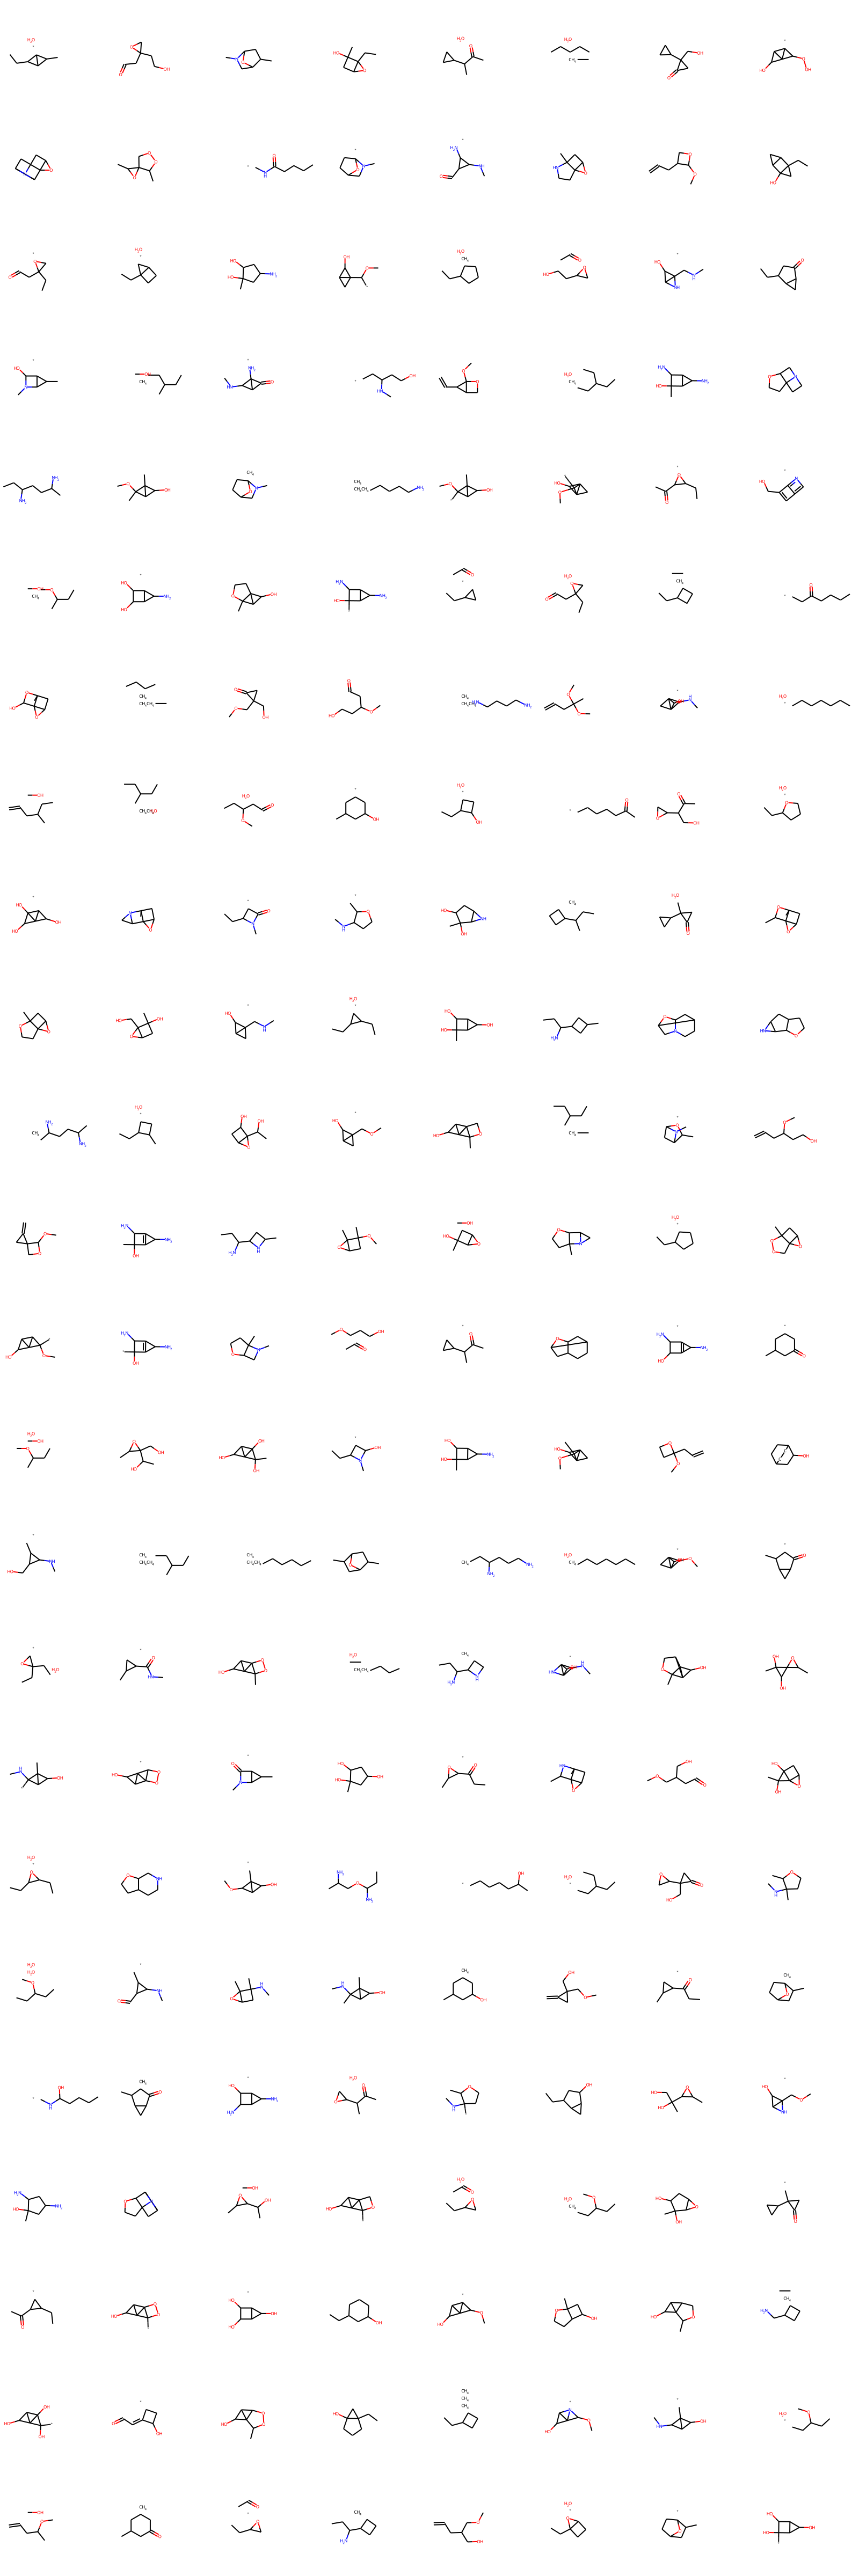

In [41]:
img

df = pd.DataFrame({'SMIELS': data} for data in s)

In [42]:
#df.to_csv('quantum-'+str(resume_iters)+'.csv', index=False)

In [43]:
from collections import defaultdict

m0, m1 = all_scores(unique_valid_mols, data, norm=True)

new_scores = defaultdict(list)

for k, v in m1.items():
    new_scores[k].append(v)
for k, v in m0.items():
    new_scores[k].append(np.array(v)[np.nonzero(v)].mean())

In [44]:
new_scores

defaultdict(list,
            {'valid': [100.0],
             'unique': [100.0],
             'novel': [87.5],
             'NP': [0.9556118224380011],
             'QED': [0.4869414527478973],
             'Solute': [0.32791688542480246],
             'SA': [0.3690632444933831],
             'diverse': [0.5830667073371075],
             'drugcand': [0.5283372930744547]})